In [2]:
from types import SimpleNamespace
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq
from scipy.signal import windows
from scipy.fft import fftshift

from nodes.radar import Radar
from nodes.phone_node import Lidar
from xwr_raw.radar_config import RadarConfig

from src.lidar_dsp import detect_planes_and_box

## Tests - Start and save

In [3]:
df = pd.DataFrame(columns=['frame', 'low', 'high', 'state', 'experiment', 'setup', 'trial'])
df.head()

,frame,low,high,state,experiment,setup,trial


In [ ]:
EXPERIMENT = 'FINDING THRESHOLD'
SETUP = 'BOX ON BOX ON THE FLOOR'
TRIAL = '0001'
# STATE = 'EMPTY'
STATE = 'FULL'

# === connect to radar
args = SimpleNamespace(**{
  'cfg': 'configs/1443_mmwavestudio_config_continuous.lua',
  'host_ip': '192.168.33.30',
  'host_data_port': 4098,
})
radar = Radar(args)

c = 3e8                                                 # speed of light - m/s
SAMPLES_PER_CHIRP = radar.params['n_samples']           # adc number of samples per chirp
SAMPLE_RATE = radar.params['sample_rate']               # digout sample rate in Hz
FREQ_SLOPE = radar.params['chirp_slope']                # frequency slope in Hz (/s)


# === connect to phone
# lidar = Lidar()
# img, depth_map, meta = lidar.read()
# floor_dist, box_dist, table_dist = detect_planes_and_box(img, depth_map, meta)
# print('Table distance', table_dist)
table_dist = 0.7
LOW = table_dist
HIGH = table_dist + 0.5



# ==== collect data from radar
frame = radar.read()
radar.close()
# avg over chirps
avg_chirps = np.mean(frame, axis=0)     # shape: (num_samples, num_rx)
# choose rx0
signal = avg_chirps                     # shape: (num_samples, num_rx)

# ==== process data from radar with fft
fft_result = fft(signal, axis=0)

rx = 0
fft_magnitude = np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, rx])
fft_freqs = fftfreq(SAMPLES_PER_CHIRP, 1/SAMPLE_RATE)
fft_meters = fft_freqs[:SAMPLES_PER_CHIRP // 2] * c / (2 * FREQ_SLOPE)

# ==== find peaks with distances
range_mask = (fft_meters >= LOW) & (fft_meters <= HIGH)
fft_magnitude_masked = fft_magnitude[range_mask]
fft_meters_masked = fft_meters[range_mask]


# ==== check if there is a strong peak at an inside box distance
THRESHOLD = 450000
detection = (fft_magnitude_masked > THRESHOLD).any()
masked_max = np.max(fft_magnitude_masked)
print('Detected:', detection)
print('Max within range:', masked_max)



# plot
plt.figure(figsize=(12, 9))
plt.plot(fft_meters,  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 0]), color='blue', label='RX1', alpha=0.7)
plt.plot(fft_meters,  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 1]), color='orange', label='RX2', alpha=0.7)
plt.plot(fft_meters,  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 2]), color='green', label='RX3', alpha=0.7)
plt.plot(fft_meters,  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 3]), color='red', label='RX4', alpha=0.7)
plt.vlines([LOW, HIGH], [0, 0], [masked_max + 1000, masked_max + 1000])
plt.title('Frequency Domain Signals')
plt.xlabel('Distance (m)')
plt.ylabel('Magnitude')
plt.legend()
plt.xlim(0,1.5)


# df.loc[-1] = [frame, LOW, HIGH, STATE, EXPERIMENT, SETUP, TRIAL]
# df.index = df.index + 1  # shifting index
# df = df.sort_index()  # sorting by index
# df.tail()

[INFO] Starting radar node with config: configs/1443_mmwavestudio_config_continuous.lua
[INFO] Connecting radar with host 192.168.33.30:4098
[INFO] Radar connected. Params:
platform                 : xWR14xx
adc_output_fmt           : 1
n_chirps                 : 32
rx                       : 1, 1, 1, 1
n_rx                     : 4
tx                       : 1, 1, 1
n_tx                     : 3
n_samples                : 512
frame_size               : 262144 bytes
frame_time               : 100 ms
chirp_time               : 162 µs
chirp_slope              : 60012000000000.0000 Hz/s
sample_rate              : 10000000.0000 samples/s
chirp_sampling_rate      : 320.0000 Hz
velocity_max             : 6.0125 m/s
velocity_res             : 0.1879 m/s
range_max                : 24.9950 m
range_res                : 0.0488 m
t_sweep                  : 0.0001 s
[INFO] Waiting for a single connection on 0.0.0.0:5005...
[INFO] Connected by ('192.168.41.99', 52087)
Table distance 0.3004636481651909

In [45]:
df.loc[-1] = [frame, LOW, HIGH, STATE, EXPERIMENT, SETUP, TRIAL]
df.index = df.index + 1  # shifting index
df = df.sort_index()  # sorting by index
df.tail()

,frame,radar-to-boxtop,radar-to-boxbtm,state,experiment,setup,trial
0,"[[[(-107+190j), (181+176j), (735+597j), (768+6...",0.65,1,FULL,FINDING THRESHOLD,BOX ON THE FLOOR,0001


In [88]:
df.head()

,frame,low,high,state,experiment,setup,trial
0,"[[[(-297+189j), (-253+631j), (2064+788j), (145...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
1,"[[[(-484-278j), (-224+16j), (1589+1672j), (157...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
2,"[[[(-451-67j), (-523+206j), (1686+1718j), (181...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
3,"[[[(-780-616j), (-1088-1234j), (-714-51j), (-2...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
4,"[[[(1029+217j), (710+533j), (531+228j), (-267-...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001


In [ ]:
# save df
import datetime
now = datetime.datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")
df.to_pickle(f'data/snap/snap_{timestamp}.pkl')

## Load and analyze

In [32]:
# load the data
df = pd.read_pickle('data/snap/snap_2025-05-09_13-34-13.pkl')

args = SimpleNamespace(**{
  'cfg': 'configs/1443_mmwavestudio_config_continuous.lua',
  'host_ip': '192.168.33.30',
  'host_data_port': 4098,
})
radar_config = RadarConfig(args.cfg)
params = radar_config.get_params()
print(radar_config)

c = 3e8                                                 # speed of light - m/s
SAMPLES_PER_CHIRP = params['n_samples']           # adc number of samples per chirp
SAMPLE_RATE = params['sample_rate']               # digout sample rate in Hz
FREQ_SLOPE = params['chirp_slope']                # frequency slope in Hz (/s)


df.info()

platform                 : xWR14xx
adc_output_fmt           : 1
n_chirps                 : 8
rx                       : 1, 1, 1, 1
n_rx                     : 4
tx                       : 1, 1, 1
n_tx                     : 3
n_samples                : 512
frame_size               : 65536 bytes
frame_time               : 100 ms
chirp_time               : 162 µs
chirp_slope              : 60012000000000.0000 Hz/s
sample_rate              : 10000000.0000 samples/s
chirp_sampling_rate      : 80.0000 Hz
velocity_max             : 6.0125 m/s
velocity_res             : 0.7516 m/s
range_max                : 24.9950 m
range_res                : 0.0488 m
t_sweep                  : 0.0001 s
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   frame       25 non-null     object 
 1   low         25 non-null     float64
 2   high        25 non-null     object 
 3   

In [33]:
_df = df.copy()
_df

,frame,low,high,state,experiment,setup,trial
0,"[[[(-321+763j), (835+1703j), (2990+2644j), (26...",0.77,1,EMPTY,FINDING THRESHOLD,BOX ON BIGBOX ON THE FLOOR,0001
1,"[[[(1488+2077j), (2074+2809j), (1284+995j), (8...",0.77,1,EMPTY,FINDING THRESHOLD,BOX ON BIGBOX ON THE FLOOR,0001
2,"[[[(-3020-2081j), (-2405-2217j), (596+1533j), ...",0.77,1,EMPTY,FINDING THRESHOLD,BOX ON BIGBOX ON THE FLOOR,0001
3,"[[[(2862+1807j), (1650+1422j), (-558-725j), (-...",0.77,1,EMPTY,FINDING THRESHOLD,BOX ON BIGBOX ON THE FLOOR,0001
4,"[[[(-698-268j), (-140+345j), (2175+1900j), (18...",0.77,1,EMPTY,FINDING THRESHOLD,BOX ON BIGBOX ON THE FLOOR,0001
5,"[[[(-1424-777j), (-904-633j), (991+1071j), (11...",0.77,1,EMPTY,FINDING THRESHOLD,BOX ON BIGBOX ON THE FLOOR,0001
6,"[[[(-1735-724j), (-1480-1056j), (-495+114j), (...",0.77,1,EMPTY,FINDING THRESHOLD,BOX ON BIGBOX ON THE FLOOR,0001
7,"[[[(721+686j), (507+1407j), (1123+723j), (550+...",0.77,1,EMPTY,FINDING THRESHOLD,BOX ON BIGBOX ON THE FLOOR,0001
8,"[[[(-1918-677j), (-853-579j), (1811+1500j), (1...",0.77,1,EMPTY,FINDING THRESHOLD,BOX ON BIGBOX ON THE FLOOR,0001
9,"[[[(-337-1288j), (-1643-2532j), (-2031-1715j),...",0.77,1,EMPTY,FINDING THRESHOLD,BOX ON BIGBOX ON THE FLOOR,0001


In [34]:
for i, row in _df.iterrows():
    frame = row['frame']
    low = row['low']
    high = row['high']

    # avg over chirps
    avg_chirps = np.mean(frame, axis=0)     # shape: (num_samples, num_rx)
    # choose rx0
    signal = avg_chirps                     # shape: (num_samples, num_rx)


    # ==== process data from radar with fft
    fft_result = fft(signal, axis=0)

    rx = 0
    fft_magnitude = np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, rx])
    fft_freqs = fftfreq(SAMPLES_PER_CHIRP, 1/SAMPLE_RATE)
    fft_meters = fft_freqs[:SAMPLES_PER_CHIRP // 2] * c / (2 * FREQ_SLOPE)

    # ==== find peaks with distances
    range_mask = (fft_meters >= low) & (fft_meters <= high)
    fft_magnitude_masked = fft_magnitude[range_mask]
    fft_meters_masked = fft_meters[range_mask]


    # ==== check if there is a strong peak at an inside box distance
    masked_max = np.max(fft_magnitude_masked)

    _df.at[i, 'fft_mag_rx0'] = np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 0]).astype(object)
    _df.at[i, 'fft_mag_rx1'] = np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 1]).astype(object)
    _df.at[i, 'fft_mag_rx2'] = np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 2]).astype(object)
    _df.at[i, 'fft_mag_rx3'] = np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 3]).astype(object)
    _df.at[i, 'fft_masked_rx0_magmax'] = masked_max

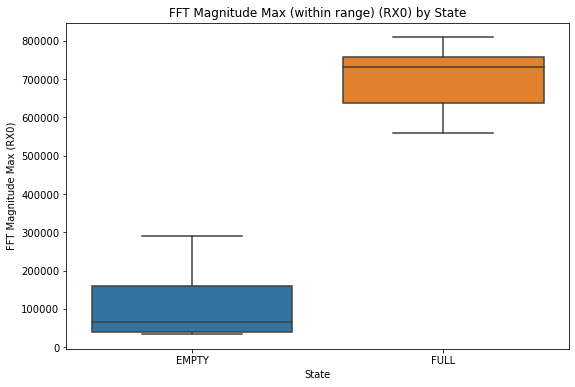

In [35]:
# distribution of fft_mag_rx0_rangemax by state
import seaborn as sns
plt.figure(figsize=(9, 6))
sns.boxplot(data=_df, x='state', y='fft_masked_rx0_magmax')
plt.title('FFT Magnitude Max (within range) (RX0) by State')
plt.xlabel('State')
plt.ylabel('FFT Magnitude Max (RX0)')
plt.show()

(0.0, 1.5)

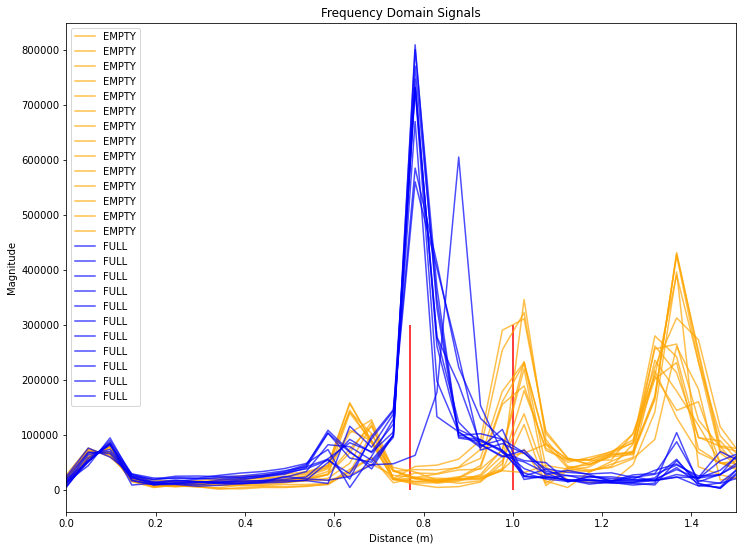

In [36]:
# plot
plt.figure(figsize=(12, 9))
LOW = _df['low'][0]
HIGH = _df['high'][0]
colors = {'FULL': 'blue', 'EMPTY': 'orange'}
for i, row in _df.iterrows():
    plt.plot(fft_meters,  np.abs(row['fft_mag_rx0']), color=colors[row['state']], alpha=0.7, label=row['state'])
plt.vlines([LOW, HIGH], [0, 0], [300000, 300000], color='red')
plt.title('Frequency Domain Signals')
plt.xlabel('Distance (m)')
plt.ylabel('Magnitude')
plt.legend()
plt.xlim(0,1.5)